In [90]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import gzip
from astropy.modeling import models, fitting

In [247]:
print('Give the overview of the fits files\n')


#uncompress the data first
with gzip.open('769/primary/acisf00769N006_evt2.fits.gz', 'rb') as f_in:
    with open('769/primary/acisf00769N006_evt2.fits', 'wb') as f_out:
        f_out.write(f_in.read())
cx_fits=fits.open('769/primary/acisf00769N006_evt2.fits')




#cx_fits=fits.open('acisf03727N004_evt2.fits')
cx_fits.info()
events=cx_fits['EVENTS'].data
print('\n Give the names of columns in the events table\n')
print(cx_fits['EVENTS'].data.names)
print('\nGive detais of the header file')
cx_fits[0].header

Give the overview of the fits files

Filename: 769/primary/acisf00769N006_evt2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  EVENTS        1 BinTableHDU    822   2274205R x 19C   [1D, 1I, 1I, 1J, 1I, 1I, 1I, 1I, 1E, 1E, 1E, 1E, 1J, 1J, 1E, 1J, 1I, 1I, 32X]   
  2  GTI           7 BinTableHDU     28   3415R x 2C   [1D, 1D]   

 Give the names of columns in the events table

['time', 'ccd_id', 'node_id', 'expno', 'chipx', 'chipy', 'tdetx', 'tdety', 'detx', 'dety', 'x', 'y', 'pha', 'pha_ro', 'energy', 'pi', 'fltgrade', 'grade', 'status']

Give detais of the header file


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HDUNAME = 'PRIMARY '                                                            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'ASC     '           / Source of FITS file                            
CREATOR = 'cxc - Version DS10.9' / tool that created this output                
CHECKSUM= 'V7AAY462V4A8V438'   / HDU checksum updated 2021-03-14T08:02:14       
DATASUM = '        '        

In [68]:
def x_y_plotter(events):
    #this function plots the spatial distribution of coordinates of the x and y
    #bascially where the event was in the sky like ra,dec thing
    #x and y are pixel units of the detector
    x= events['x']
    y= events['y']
    
    #Hence first define bin_size for giving details
    #more the bin the lesser resolved the image
    bin_size=1
    
    #Find the highest rounded int vals in x and y and hence define the sizes for x and y axis
    image_x_size=int(np.ceil(np.max(x)/bin_size))
    image_y_size=int(np.ceil(np.max(y)/bin_size))
    #make a empty image array of the x_size and y_size
    image=np.zeros((image_y_size, image_x_size))
    
    #now we need to fill the array according to position of the source in x and y hences
    #obtaine the indices of the array where there is a detection
    x_indices= np.floor(x/bin_size).astype(int)
    y_indices= np.floor(y/bin_size).astype(int)
    
    #afterwards fill the indices in the image array in positions where there is a detection as 1 
    #any arbitary val by doing += 1 operation
    image[y_indices, x_indices]+=1
    
    intensity_distribution = np.mean(image, axis=1)
    minvalue=np.min(np.where(intensity_distribution>0)[0]) - 50
    maxvalue=np.max(np.where(intensity_distribution>0)[0])+ 50
    
    # Display the reconstructed image
    plt.imshow(image[minvalue:maxvalue,minvalue:maxvalue]
               ,origin='lower', cmap='plasma',
              vmax=1, vmin=0.7)
    plt.colorbar()
    plt.title("Spatial distribution of pixels on detector plane")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.show()


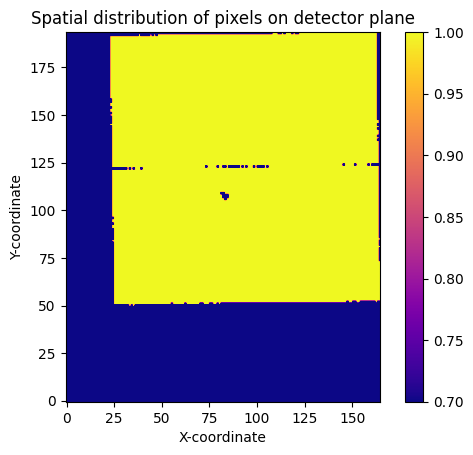

In [69]:
x_y_plotter(events)

In [91]:
def energy_time_hist(events, energy_bin, time_bin):
    energy=events['energy']
    time=events['time']

    plt.title('Energy Time distribution')
    plt.xlabel('Time in hrs')
    plt.ylabel('Energy in kev')
    plt.hist2d(np.max(time)/3600-time/3600,energy/1000,
               bins=[energy_bin,time_bin])

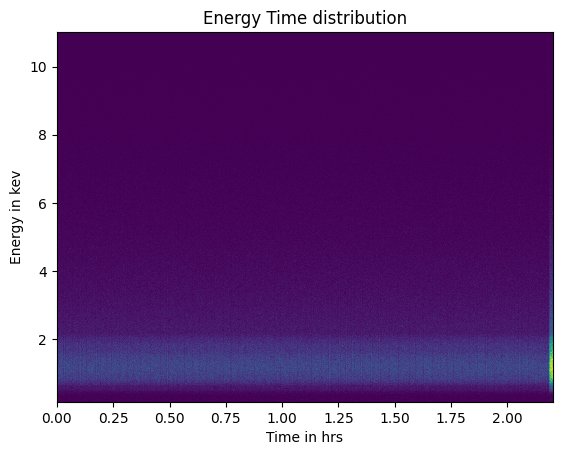

In [92]:
energy_time_hist(events, 500, 500)

In [35]:
def energy_hist(events, energy_min, energy_max):
    energy=events['energy']/1000 #convert the ev to kev 
    # Filter the energy values within the specified range
    energy_range = energy[(energy >= energy_min) & (energy <= energy_max)]
    plt.title('Energy distribution')
    plt.xlabel('Energy in kev')
    plt.ylabel('Counts')
    plt.hist(energy_range, bins=500)
    

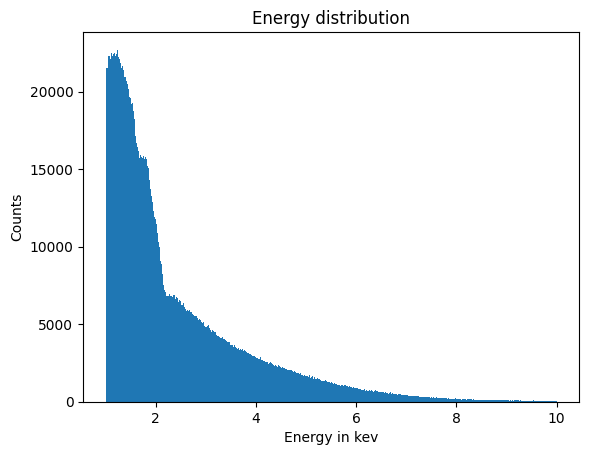

In [36]:
energy_hist(events, 1.0, 10.0)


In [122]:
def energy_spectrum(events, min_ener, max_ener):
    energy=events['energy'] #it is in ev 
    energy_min = min_ener*1000 #0.0  # Minimum energy in eV
    energy_max = max_ener*1000  # Maximum energy in eV
    selected_events = events[(energy >= energy_min) & (energy <= energy_max)]
    counts, _ = np.histogram(selected_events['ENERGY'], 
                               bins=100, 
                               range=(energy_min, energy_max))
    energy_binned = np.linspace(energy_min, energy_max, num=101)[:-1] + 0.5 * (energy_max - energy_min) / 100
    
    plt.figure(figsize=(8, 5))
    plt.plot(energy_binned/1000, counts, color='black')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.title('X-ray Spectrum')
    plt.show()


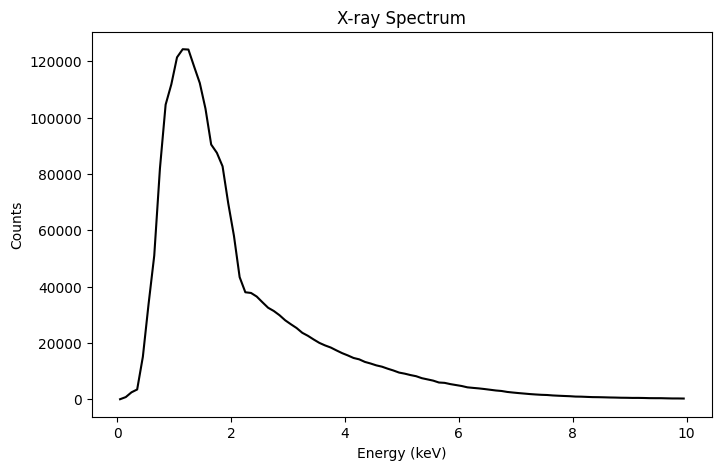

In [123]:
energy_spectrum(events, 0,10.0)

In [241]:
def model_to_spectra(events, min_ener, max_ener):
    energy=events['energy'] #it is in ev 
    energy_min = min_ener*1000 #0.0  # Minimum energy in eV
    energy_max = max_ener*1000  # Maximum energy in eV
    selected_events = events[(energy >= energy_min) & (energy <= energy_max)]
    counts, _ = np.histogram(selected_events['ENERGY'], 
                               bins=100, 
                               range=(energy_min, energy_max))
    energy_binned = np.linspace(energy_min, energy_max, num=101)[:-1] + 0.5 * (energy_max - energy_min) / 100
    
    make_model = models.Gaussian1D()
    energy_log = np.log(energy_binned)
    fitter = fitting.LevMarLSQFitter()
    model_fit = fitter(make_model, energy_log, counts)
    
    energy_fit = np.linspace(np.min(energy_log), np.max(energy_log))
    counts_fit = powerlaw_fit(energy_fit)
    
    
    plt.figure(figsize=(8, 5))
    plt.plot(energy_fit, counts_fit, label='Gaussian Fit', color='red')
    plt.scatter(energy_log, counts, label='Data',marker='o')
    plt.xlabel('Log(Energy in ev)')
    plt.ylabel('Counts')
    plt.title('X-ray Spectrum')
    plt.legend()
    plt.show()

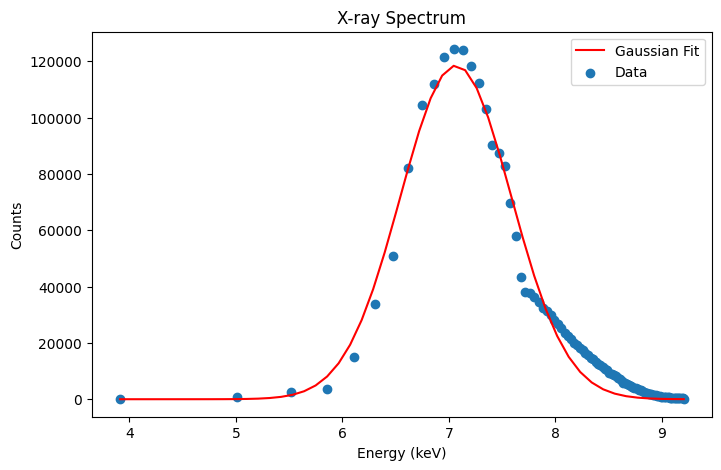

In [242]:
power_law(events, 0,10)

In [29]:
def image_plotter(input_gz,output_fits):
    #PLOT THE ACIS fits image with this function
    
    #uncompress the data first
    with gzip.open(input_gz, 'rb') as f_in:
        with open(output_fits, 'wb') as f_out:
            f_out.write(f_in.read())
    img_fits=fits.open(output_fits)
    
    print(img_fits.info())
    
    #THIS IS THE NON CONTRASTED DATA
    img=img_fits[0].data
    
    #do a 1d intensity level distribution accros pixels to get a magnified image from 
    #NON CONTRASTED DATA
    intensity_distribution = np.mean(img, axis=1)
    minvalue=np.min(np.where(intensity_distribution>0)[0]) - 100
    maxvalue=np.max(np.where(intensity_distribution>0)[0])+ 100
    
    #DO CONTRAST CORRECTION
    img = img.astype(float)  # Convert to floating-point for accurate calculations
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    # Step 2: Define the contrast stretch parameters
    contrast_min = 0.3 # Lower bound of the desired contrast range (adjust this value)
    contrast_max = 1.0  # Upper bound of the desired contrast range (adjust this value)
    # Step 3: Apply the contrast stretch
    contrast_stretched_image = (img - contrast_min) / (contrast_max - contrast_min)
    contrast_stretched_image = np.clip(contrast_stretched_image, 0.0, 1.0)  # Ensure values are within the valid range
    
    
    #PLOT THE IMAGES SIDE-BY-SIDE
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.title('Chandra acis image')
    
    
    plt.imshow(img[minvalue:maxvalue,minvalue:maxvalue],
               cmap='viridis', vmax=1.0, vmin=0.3)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Chandra acis image, contrasted')
    plt.imshow(contrast_stretched_image[minvalue:maxvalue,minvalue:maxvalue],
               cmap='viridis', vmax=1.0, vmin=0.3)
    plt.axis('off')
    plt.savefig('chandra_acis.jpg')

Filename: 769/primary/acisf00769N006_cntr_img2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     793   (1025, 1024)   int32   
  1  GTI           7 BinTableHDU     28   3415R x 2C   [1D, 1D]   
None


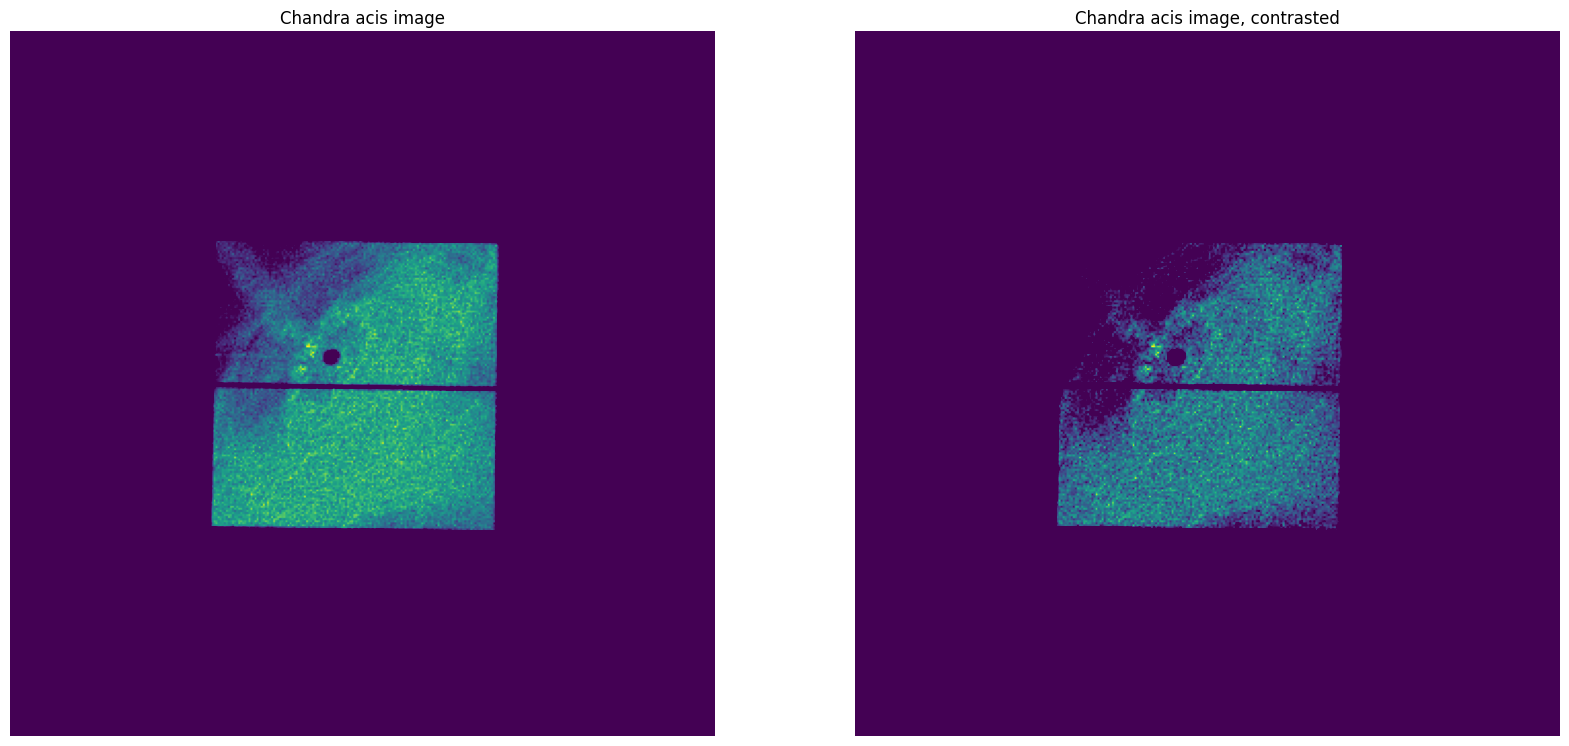

In [49]:

input_gz='769/primary/acisf00769N006_cntr_img2.fits.gz'
output_fits='769/primary/acisf00769N006_cntr_img2.fits'
image_plotter(input_gz,output_fits)